### 1. Imports and Setup

In [41]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Reshape, LSTM, GRU, Bidirectional, Input,
    Concatenate, Multiply
)
from tensorflow.keras.preprocessing import image
from transformers import ViTImageProcessor, TFViTForImageClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


### 2. Data Downloading and Preparation

In [ ]:
try:
    path = kagglehub.dataset_download("marcozuppelli/stegoimagesdataset")
    print("Path to dataset files:", path)
    source_path = path
    destination_path = '/content/stegoimagesdataset'

    if os.path.exists(destination_path):
        shutil.rmtree(destination_path)
    os.makedirs(destination_path, exist_ok=True)

    for item in os.listdir(source_path):
        s = os.path.join(source_path, item)
        d = os.path.join(destination_path, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Data copied to {destination_path}")
except Exception as e:
    print(f"Could not download from Kaggle Hub. Error: {e}")
    destination_path = '/content/stegoimagesdataset'
    if not os.path.exists(destination_path):
        raise FileNotFoundError("Dataset not found.")

Path to dataset files: /kaggle/input/stegoimagesdataset
Data copied to /content/stegoimagesdataset


In [ ]:
def segregate_data_by_payload(original_data_path, new_base_path):
    print("\nSegregating data by payload type...")
    for split in ['train', 'test', 'val']:
        stego_path = os.path.join(original_data_path, split, split, 'stego')
        clean_path = os.path.join(original_data_path, split, split, 'clean')
        new_split_path = os.path.join(new_base_path, split)

        if os.path.exists(stego_path):
            for img_name in os.listdir(stego_path):
                try:
                    payload_class = img_name.split("_")[2]
                    class_dir = os.path.join(new_split_path, payload_class)
                    os.makedirs(class_dir, exist_ok=True)
                    shutil.copy(os.path.join(stego_path, img_name), class_dir)
                except IndexError:
                    print(f"Skipping file with unexpected name format: {img_name}")

        if os.path.exists(clean_path):
            new_clean_path = os.path.join(new_split_path, 'clean')
            shutil.copytree(clean_path, new_clean_path, dirs_exist_ok=True)
    print("Data segregation complete.")

new_data_path = "new_data"
if os.path.exists(new_data_path):
    shutil.rmtree(new_data_path)
segregate_data_by_payload(destination_path, new_data_path)


Segregating data by payload type...
Data segregation complete.


In [ ]:
def combine_and_resplit(source_base_path, final_base_path, train_ratio=0.8, test_ratio=0.1):
    print("\nCombining and re-splitting data...")
    all_files_by_class = {}
    for class_name in os.listdir(os.path.join(source_base_path, 'train')):
        all_files_by_class[class_name] = []
        for split in ['train', 'test', 'val']:
            class_folder = os.path.join(source_base_path, split, class_name)
            if os.path.exists(class_folder):
                all_files_by_class[class_name].extend([os.path.join(class_folder, f) for f in os.listdir(class_folder)])

    if os.path.exists(final_base_path):
        shutil.rmtree(final_base_path)

    for class_name, files in all_files_by_class.items():
        train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=42)
        val_ratio = 1 - (test_ratio / (1 - train_ratio))
        val_files, test_files = train_test_split(temp_files, train_size=val_ratio, random_state=42)

        for split_name, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            dest_dir = os.path.join(final_base_path, split_name, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for f in file_list:
                shutil.copy(f, dest_dir)
    print("Data re-splitting complete.")

final_data_path = "final_payload_data"
combine_and_resplit(new_data_path, final_data_path)


Combining and re-splitting data...
Data re-splitting complete.


In [ ]:
IMG_SIZE_GENERAL = 512
IMG_SIZE_VIT = 224
BATCH_SIZE = 128

print(f"\nLoading data for general models (CNN, RNNs) with image size {IMG_SIZE_GENERAL}x{IMG_SIZE_GENERAL}...")
train_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "train"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=True, seed=123
)
val_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "val"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=False, seed=123
)
test_dataset_gen = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "test"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_GENERAL, IMG_SIZE_GENERAL),
    batch_size=BATCH_SIZE, shuffle=False
)

print(f"\nLoading data for ViT model with image size {IMG_SIZE_VIT}x{IMG_SIZE_VIT}...")
train_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "train"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=True, seed=123
)
val_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "val"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=False, seed=123
)
test_dataset_vit = tf.keras.utils.image_dataset_from_directory(
    os.path.join(final_data_path, "test"),
    labels='inferred', label_mode='int',
    image_size=(IMG_SIZE_VIT, IMG_SIZE_VIT),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_dataset_gen.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")


Loading data for general models (CNN, RNNs) with image size 512x512...
Found 25599 files belonging to 6 classes.
Found 3197 files belonging to 6 classes.
Found 3204 files belonging to 6 classes.

Loading data for ViT model with image size 224x224...
Found 25599 files belonging to 6 classes.
Found 3197 files belonging to 6 classes.
Found 3204 files belonging to 6 classes.
Found 6 classes: ['clean', 'eth', 'html', 'js', 'ps', 'url']


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

def prepare(ds, augment=False):
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds_gen = prepare(train_dataset_gen, augment=False)
val_ds_gen = prepare(val_dataset_gen)
test_ds_gen = prepare(test_dataset_gen)

train_ds_vit = prepare(train_dataset_vit, augment=False)
val_ds_vit = prepare(val_dataset_vit)
test_ds_vit = prepare(test_dataset_vit)

### 3. Individual Model Definitions

In [ ]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # input_shape must be explicitly defined here now
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', name='feature_layer'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="CNN_Model")
    return model

def build_rnn_model(input_shape, num_classes, rnn_type='lstm'):
    features_per_timestep = input_shape[1] * input_shape[2]
    timesteps = input_shape[0]
    RNN_LAYER = LSTM if rnn_type.lower() == 'lstm' else GRU

    model = Sequential([
        Reshape((timesteps, features_per_timestep), input_shape=input_shape),
        Bidirectional(RNN_LAYER(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(RNN_LAYER(64, name='feature_layer')),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=f"{rnn_type.upper()}_Model")
    return model

def build_vit_model(num_classes):
    model_name = "google/vit-base-patch16-224-in21k"
    model = TFViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    return model

In [ ]:
input_shape_gen = (IMG_SIZE_GENERAL, IMG_SIZE_GENERAL, 3)
cnn_model = build_cnn_model(input_shape_gen, num_classes)
lstm_model = build_rnn_model(input_shape_gen, num_classes, rnn_type='lstm')
gru_model = build_rnn_model(input_shape_gen, num_classes, rnn_type='gru')
vit_model = build_vit_model(num_classes)

print("--- CNN Model Summary ---")
cnn_model.summary()
print("\n--- LSTM Model Summary ---")
lstm_model.summary()
print("\n--- GRU Model Summary ---")
gru_model.summary()
print("\n--- ViT Model (structure) ---")
print(f"ViT model loaded: {vit_model.name}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse 

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should proba

--- CNN Model Summary ---


Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,074,246 (240.61 MB)

 Trainable params: 63,074,246 (240.61 MB)

 Non-trainable params: 0 (0.00 B)


--- LSTM Model Summary ---


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 512, 1536)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512, 256)       │     1,704,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,886,598 (7.20 MB)

 Trainable params: 1,886,598 (7.20 MB)

 Non-trainable params: 0 (0.00 B)


--- GRU Model Summary ---


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 512, 1536)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 512, 256)       │     1,279,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,422 (5.42 MB)

 Trainable params: 1,420,422 (5.42 MB)

 Non-trainable params: 0 (0.00 B)


--- ViT Model (structure) ---
ViT model loaded: tf_vi_t_for_image_classification


### 4. Model Training

In [ ]:
models = {
    "CNN": cnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model,
}

histories = {}
trained_models = {}

vit_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for name, model in models.items():
    print(f"\n--- Training {name} Model ---")

    if name == 'CNN':
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_ds_gen,
            validation_data=val_ds_gen,
            epochs=20,
            verbose=1
        )

    else:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_ds_gen,
            validation_data=val_ds_gen,
            epochs=10,
            verbose=1
        )

    histories[name] = history
    trained_models[name] = model
    print(f"--- {name} Model Training Complete ---")


--- Training CNN Model ---
Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 105s 353ms/step - accuracy: 0.2085 - loss: 146.7935 - val_accuracy: 0.2906 - val_loss: 1.6865
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - accuracy: 0.4104 - loss: 1.3664 - val_accuracy: 0.8686 - val_loss: 0.3910
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - accuracy: 0.8393 - loss: 0.3945 - val_accuracy: 0.9231 - val_loss: 0.2197
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9281 - loss: 0.2153 - val_accuracy: 0.9737 - val_loss: 0.0984
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9645 - loss: 0.1208 - val_accuracy: 0.9762 - val_loss: 0.0914
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - accuracy: 0.9755 - loss: 0.0866 - val_accuracy: 0.9828 - val_loss: 0.0714
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.9792 - loss: 0.0747 - val_accuracy: 0.9825 - val_loss: 0.0681
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/st

In [ ]:
models["ViT"] = vit_model

In [ ]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Transpose the image data to be in channels-first format (batch_size, channels, height, width)
    image = tf.transpose(image, perm=[0, 3, 1, 2])
    return image, label


# Build the tf.data pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing
ds_train = train_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_val = val_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_test = test_dataset_vit.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


# # 5. COMPILE AND TRAIN THE MODEL
# learning_rate = 5e-5

# Instead of instantiating the optimizer here, pass the string identifier
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

models["ViT"].compile(
    optimizer='adam', # Pass optimizer as a string
    loss=loss,
    metrics=['accuracy']
)

In [19]:
print("--- Starting Fine-Tuning ---")
history = models["ViT"].fit(
    ds_train,
    validation_data=ds_val,
    epochs=20
)

print("\n--- Fine-Tuning Complete ---")

--- Starting Fine-Tuning ---
Epoch 1/20
200/200 [==============================] - 148s 533ms/step - loss: 0.8743 - accuracy: 0.5790 - val_loss: 0.8677 - val_accuracy: 0.5724
Epoch 2/20
200/200 [==============================] - 103s 516ms/step - loss: 0.6130 - accuracy: 0.6937 - val_loss: 0.4009 - val_accuracy: 0.7873
Epoch 3/20
200/200 [==============================] - 103s 516ms/step - loss: 0.3652 - accuracy: 0.8089 - val_loss: 0.3471 - val_accuracy: 0.8561
Epoch 4/20
200/200 [==============================] - 103s 517ms/step - loss: 0.4003 - accuracy: 0.8022 - val_loss: 0.3734 - val_accuracy: 0.7914
Epoch 5/20
200/200 [==============================] - 103s 516ms/step - loss: 0.2588 - accuracy: 0.8902 - val_loss: 0.2298 - val_accuracy: 0.9349
Epoch 6/20
200/200 [==============================] - 103s 516ms/step - loss: 0.1432 - accuracy: 0.9561 - val_loss: 0.1382 - val_accuracy: 0.9590
Epoch 7/20
200/200 [==============================] - 103s 516ms/step - loss: 0.1126 - accuracy

### 5. Individual Model Evaluation

In [20]:
def plot_roc_curve(y_true, y_pred_proba, num_classes, class_names, model_name):
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = np.trapz(tpr[i], fpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = np.trapz(tpr["micro"], fpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(model, test_ds, model_name, is_vit=False):
    print(f"\n--- Evaluating {model_name} Model ---")
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    predictions_list = []
    for data_batch, labels_batch in test_ds:
        if is_vit:
            # Apply preprocessing for ViT model
            images = tf.image.convert_image_dtype(data_batch, dtype=tf.float32)
            images = tf.transpose(images, perm=[0, 3, 1, 2])
            # The ViT model expects a dictionary input with 'pixel_values'
            # Extract the logits from the prediction output
            preds = model.predict({'pixel_values': images}).logits
            predictions_list.append(preds)
        else:
            preds = model.predict(data_batch)
            predictions_list.append(preds)

    predictions = np.concatenate(predictions_list, axis=0)


    y_pred_proba = predictions
    if is_vit:
        # The predictions are already logits, so no need to access .logits again
        y_pred_proba = tf.nn.softmax(predictions, axis=-1).numpy()


    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Multi-class Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} (Multi-class)")
    plt.show()

    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"Weighted Average ROC-AUC Score (Multi-class): {roc_auc:.4f}")
        plot_roc_curve(y_true, y_pred_proba, num_classes, class_names, f"{model_name} (Multi-class)")
    except Exception as e:
        print(f"Could not calculate Multi-class ROC-AUC score: {e}")

    # Binary Classification (Clean vs Not Clean)
    print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

    # Map true labels to binary (0 for clean, 1 for not clean)
    y_true_binary = np.where(y_true == class_names.index('clean'), 0, 1)

    # Map predicted classes to binary (0 for clean, 1 for not clean)
    y_pred_binary = np.where(y_pred == class_names.index('clean'), 0, 1)

    # Calculate predicted probabilities for binary classification
    # Probability of 'clean' class is the probability of class 0
    # Probability of 'not clean' is 1 - probability of class 0
    y_pred_proba_binary = np.vstack((y_pred_proba[:, class_names.index('clean')], 1 - y_pred_proba[:, class_names.index('clean')])).T


    print("Binary Classification Report:")
    print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

    cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
    disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
    disp_binary.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} (Clean vs. Not Clean)")
    plt.show()

    try:
        # ROC-AUC for binary classification
        roc_auc_binary = roc_auc_score(y_true_binary, y_pred_proba_binary[:, 1]) # Use probability of 'not clean' class
        print(f"ROC-AUC Score (Clean vs. Not Clean): {roc_auc_binary:.4f}")

        # Plot binary ROC curve
        fpr_binary, tpr_binary, _ = roc_curve(y_true_binary, y_pred_proba_binary[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_binary, tpr_binary, label=f'ROC curve (area = {roc_auc_binary:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Binary ROC Curve for {model_name} (Clean vs. Not Clean)')
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print(f"Could not calculate Binary ROC-AUC score: {e}")

In [21]:
trained_models["ViT"] = models["ViT"]


--- Evaluating CNN Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━

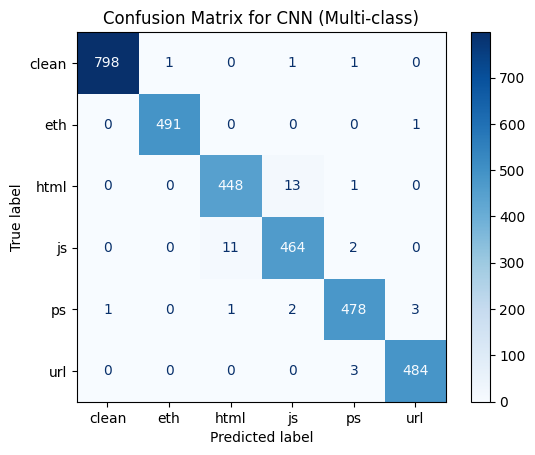

Weighted Average ROC-AUC Score (Multi-class): 0.9997


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

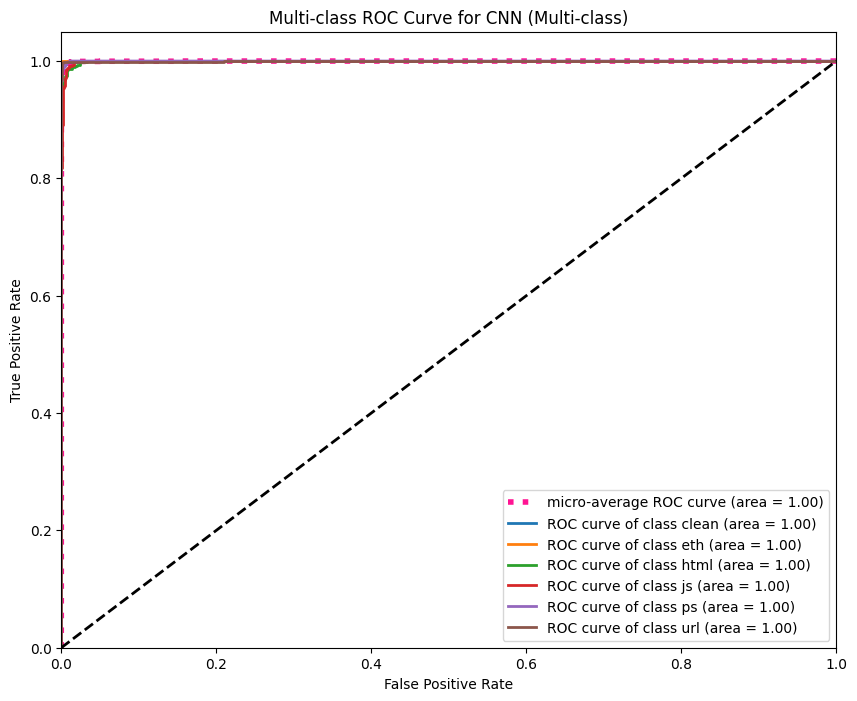


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



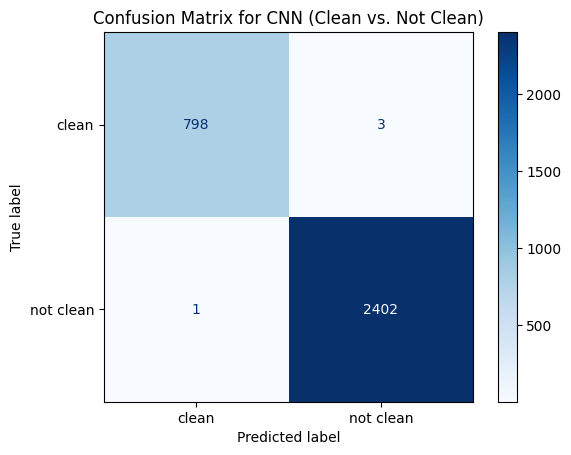

ROC-AUC Score (Clean vs. Not Clean): 1.0000


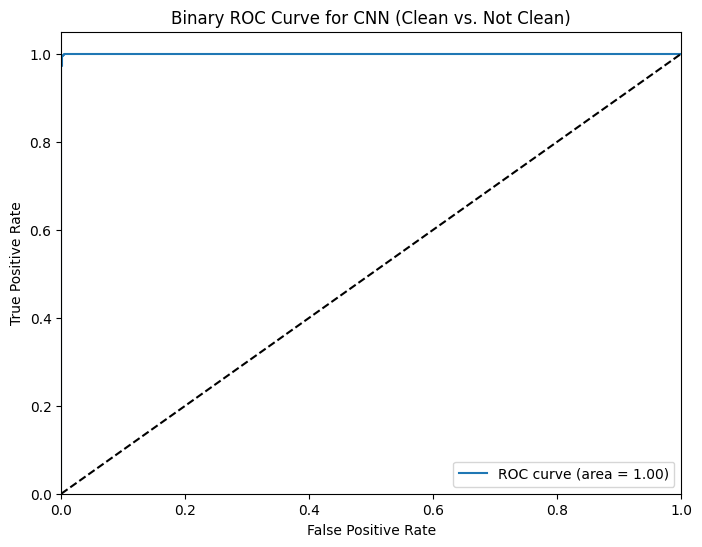


--- Evaluating LSTM Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━

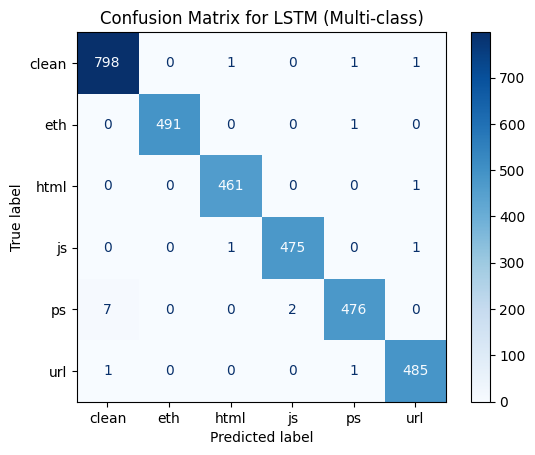

Weighted Average ROC-AUC Score (Multi-class): 1.0000


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

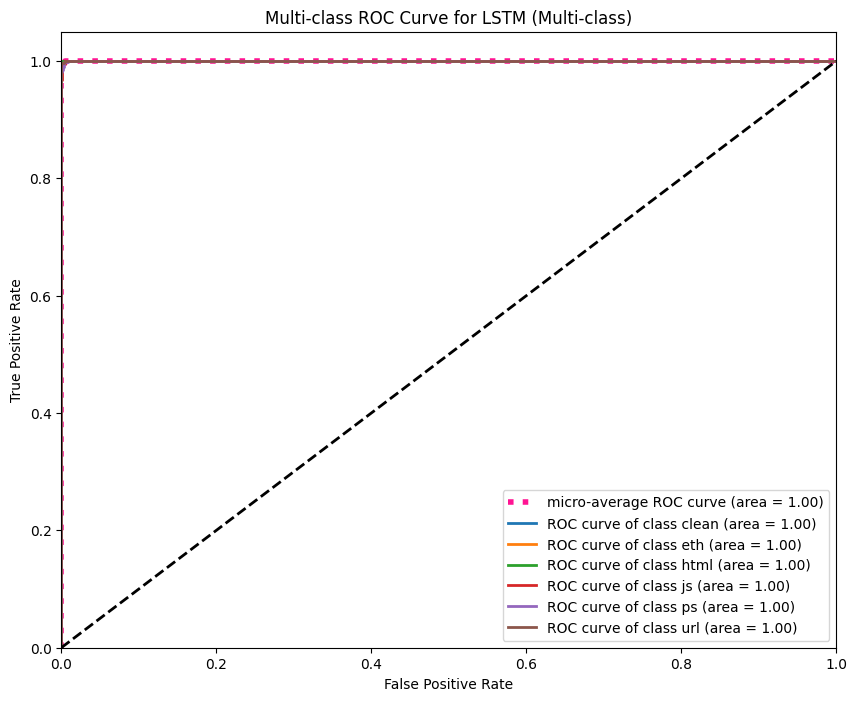


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.99      1.00      0.99       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       0.99      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



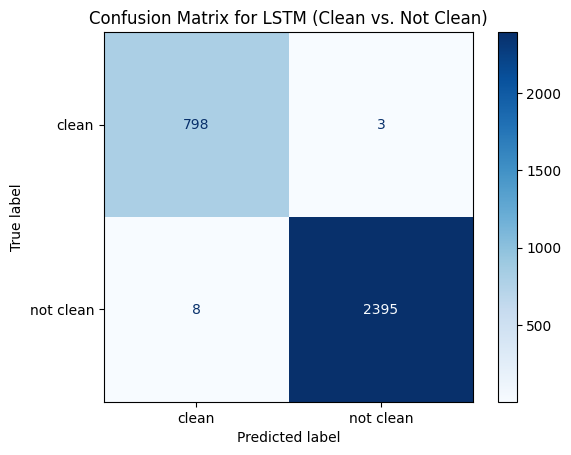

ROC-AUC Score (Clean vs. Not Clean): 1.0000


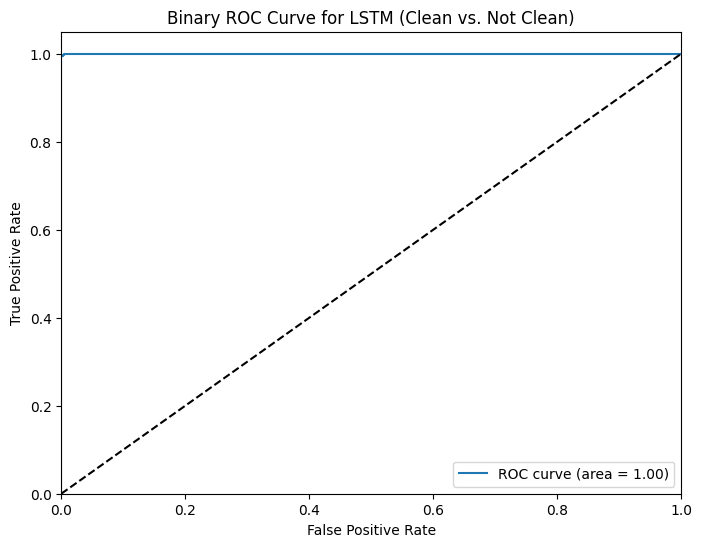


--- Evaluating GRU Model ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━

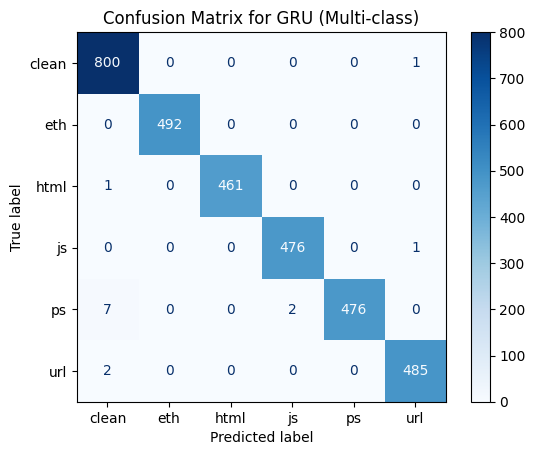

Weighted Average ROC-AUC Score (Multi-class): 0.9999


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

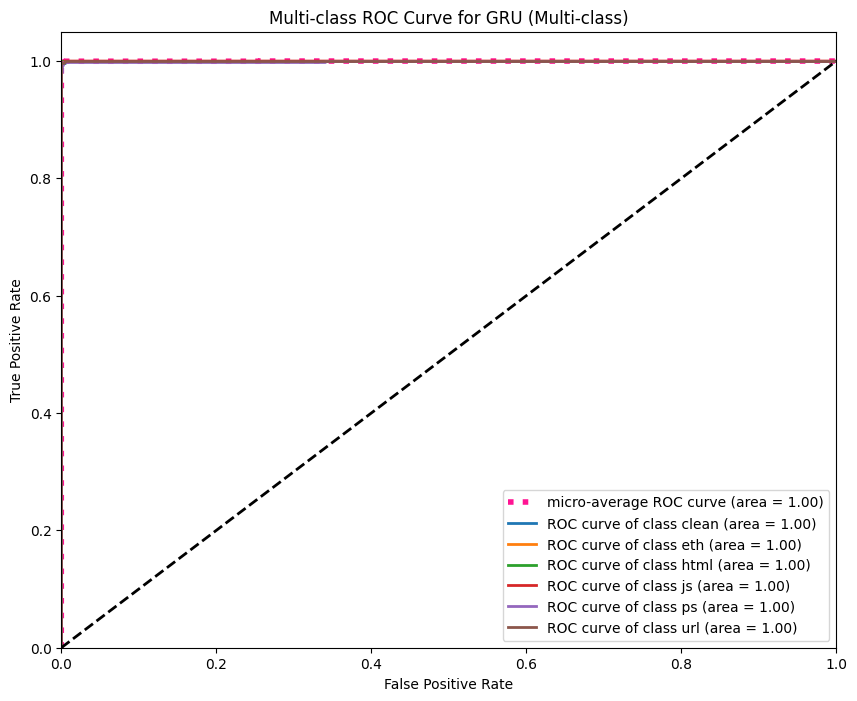


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.99      1.00      0.99       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       0.99      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



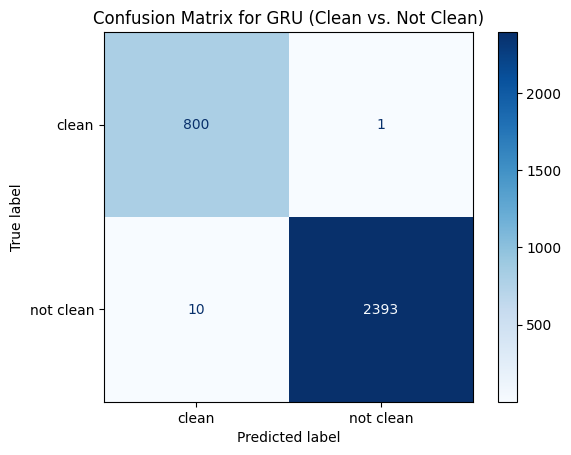

ROC-AUC Score (Clean vs. Not Clean): 1.0000


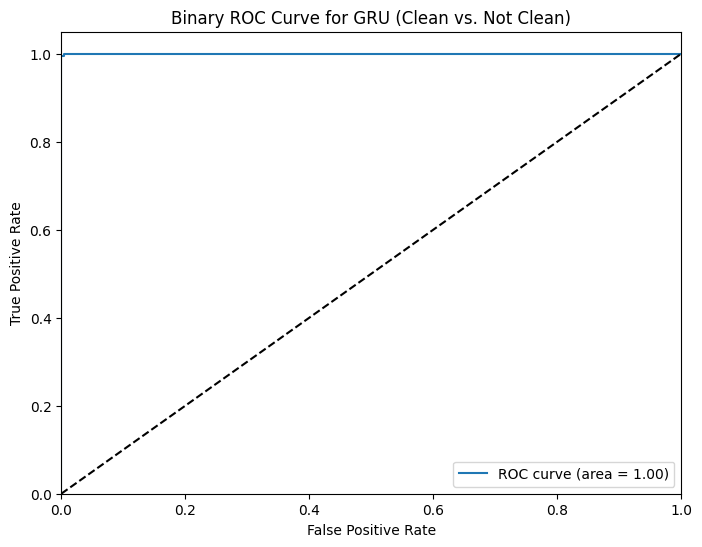


--- Evaluating ViT Model ---
1/1 [==============================] - 3s 3s/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       0.98      0.99      0.98       801
         eth       0.97      0.99      0.98       492
        html       0.96      0.96      0.96       462
          js       0.97      0.95      0.96       477
          ps       1.00      0.98      0.99       485
         url       0.99      0.99      0.99       487

    accuracy                           0.98      3204
   macro avg       0.98      0.98      0.98      3204
weighted avg       0.98      0.98      0.98      3204



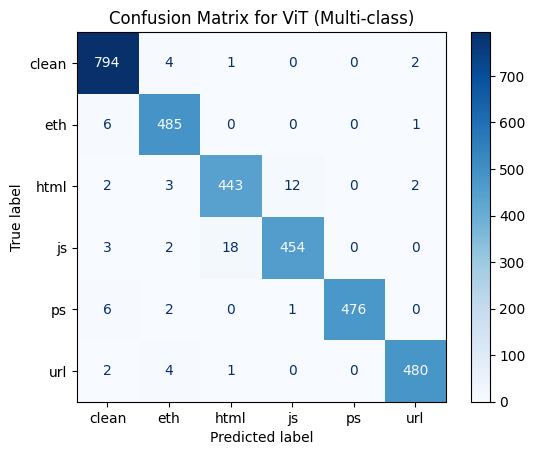

Weighted Average ROC-AUC Score (Multi-class): 0.9989


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

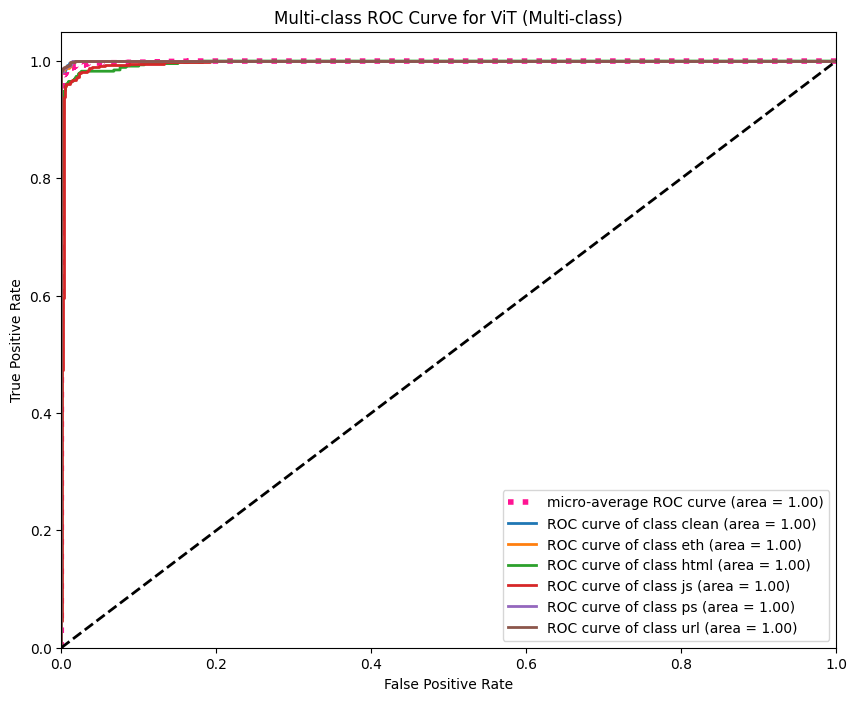


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.98      0.99      0.98       801
   not clean       1.00      0.99      0.99      2403

    accuracy                           0.99      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       0.99      0.99      0.99      3204



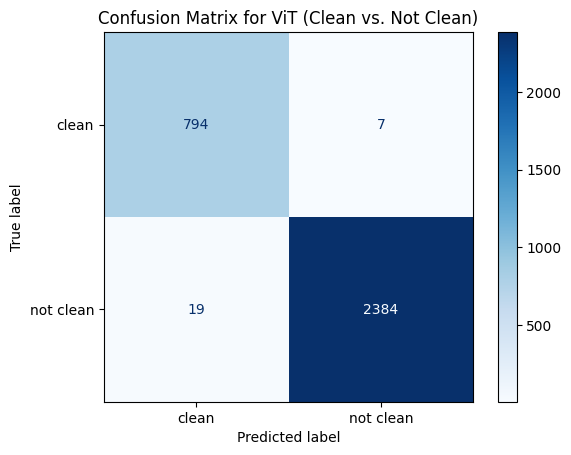

ROC-AUC Score (Clean vs. Not Clean): 0.9999


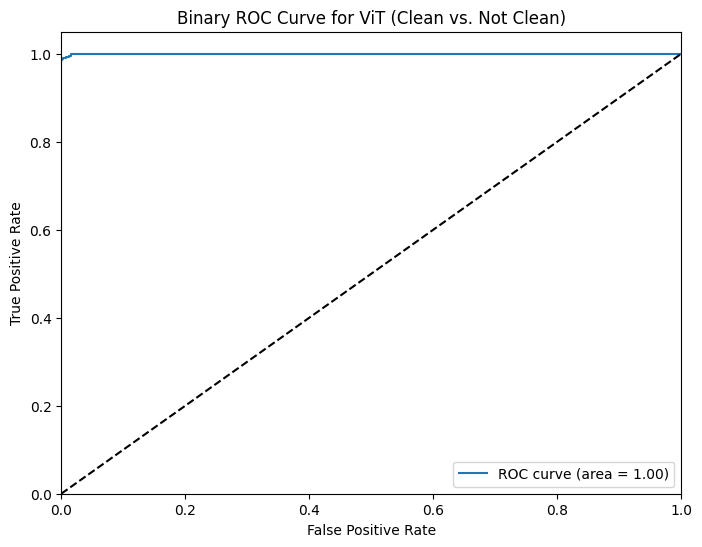

In [23]:
for name, model in trained_models.items():
    is_vit_model = (name == "ViT")
    current_test_ds = test_ds_vit if is_vit_model else test_ds_gen

    evaluate_model(model, current_test_ds, name, is_vit=is_vit_model)

### 6. Combination Technique 1: Feature Fusion

In [26]:
print("\n--- Combination Technique 1: Feature Fusion ---")

# Build the models with a sample input to define their input shapes
sample_input_gen = tf.random.uniform((1, *input_shape_gen))


cnn_model(sample_input_gen)
lstm_model(sample_input_gen)
gru_model(sample_input_gen)

feature_extractors = {}

# Note: Ensure your cnn_model has a layer explicitly named 'feature_layer'
feature_extractors['CNN'] = Model(
    inputs=cnn_model.inputs,
    outputs=cnn_model.get_layer('feature_layer').output,
    name="CNN_Feature_Extractor"
)

feature_extractors['LSTM'] = Model(
    inputs=lstm_model.inputs,
    outputs=lstm_model.get_layer('bidirectional_1').output,
    name="LSTM_Feature_Extractor"
)

feature_extractors['GRU'] = Model(
    inputs=gru_model.inputs,
    outputs=gru_model.get_layer('bidirectional_3').output,
    name="GRU_Feature_Extractor"
)

print("✅ Feature extractors created successfully!")
for name, model in feature_extractors.items():
    print(f"  - {name} output shape: {model.output_shape}")


--- Combination Technique 1: Feature Fusion ---
✅ Feature extractors created successfully!
  - CNN output shape: (None, 128)
  - LSTM output shape: (None, 128)
  - GRU output shape: (None, 128)


In [27]:
def extract_features_from_model(model, dataset, is_vit=False):
    features_list = []
    labels_list = []

    dataset_to_use = dataset
    if is_vit:
        dataset_to_use = dataset.map(lambda x, y: ({'pixel_values': x}, y))

    for data_batch, labels_batch in dataset_to_use:
        feats = model.predict(data_batch)
        features_list.append(feats)
        labels_list.append(labels_batch.numpy())

    return np.concatenate(features_list), np.concatenate(labels_list)

train_features, val_features, test_features = {}, {}, {}
train_labels, val_labels, test_labels = None, None, None

for name, extractor in feature_extractors.items():
    print(f"Extracting features using {name}...")
    is_vit = (name == 'ViT')

    current_train_ds = train_ds_vit if is_vit else train_ds_gen
    current_val_ds = val_ds_vit if is_vit else val_ds_gen
    current_test_ds = test_ds_vit if is_vit else test_ds_gen

    train_features[name], temp_train_labels = extract_features_from_model(extractor, current_train_ds, is_vit)
    val_features[name], temp_val_labels = extract_features_from_model(extractor, current_val_ds, is_vit)
    test_features[name], temp_test_labels = extract_features_from_model(extractor, current_test_ds, is_vit)

    if train_labels is None:
        train_labels = temp_train_labels
        val_labels = temp_val_labels
        test_labels = temp_test_labels

print("\nFeatures extracted for all models.")

Extracting features using CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
4/4 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(32, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━


--- Concatenation Fusion ---

Fusing models: CNN, LSTM
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       0.99      1.00      1.00       492
        html       0.96      0.98      0.97       462
          js       0.97      0.97      0.97       477
          ps       1.00      0.99      0.99       485
         url       1.00      1.00      1.00       487

    accuracy                           0.99      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       0.99      0.99      0.99      3204



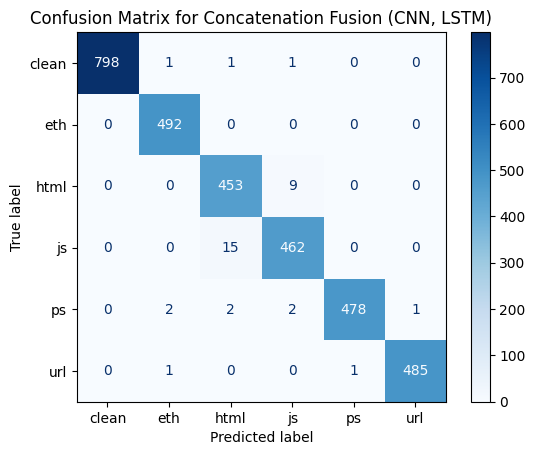

Weighted Average ROC-AUC Score (Multi-class): 0.9998


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

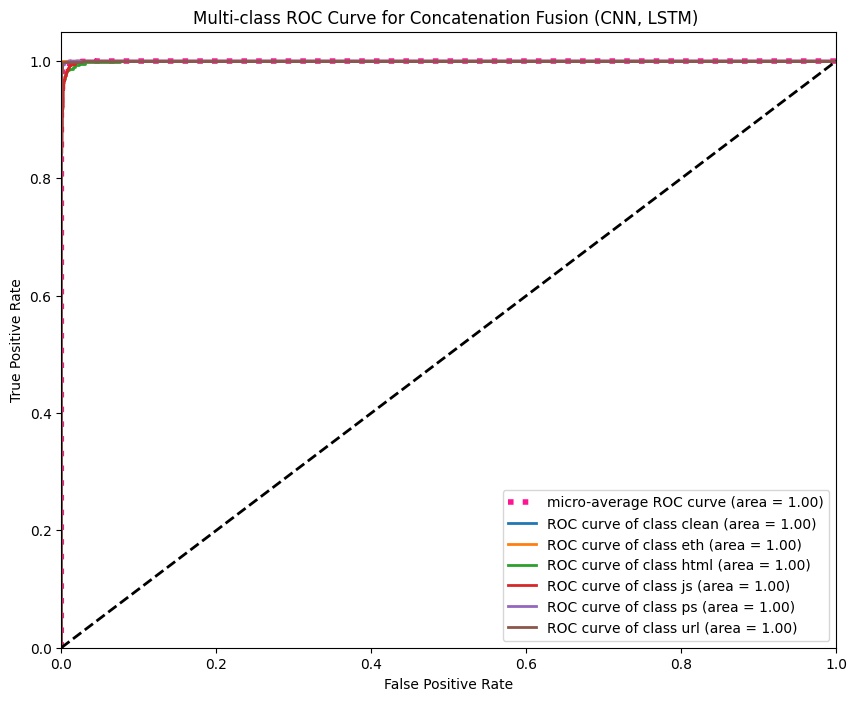


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



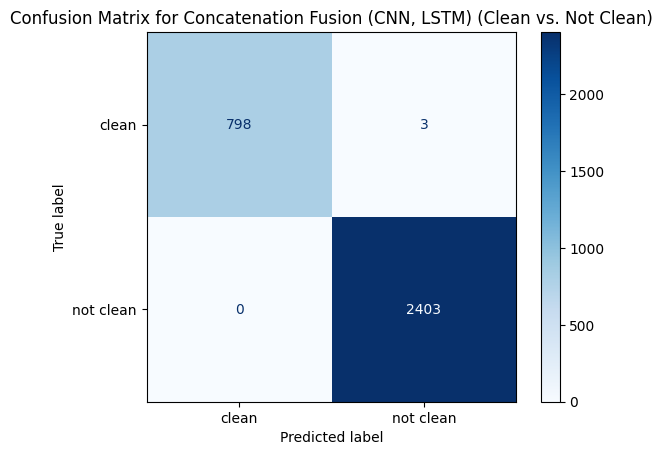

ROC-AUC Score (Clean vs. Not Clean): 1.0000


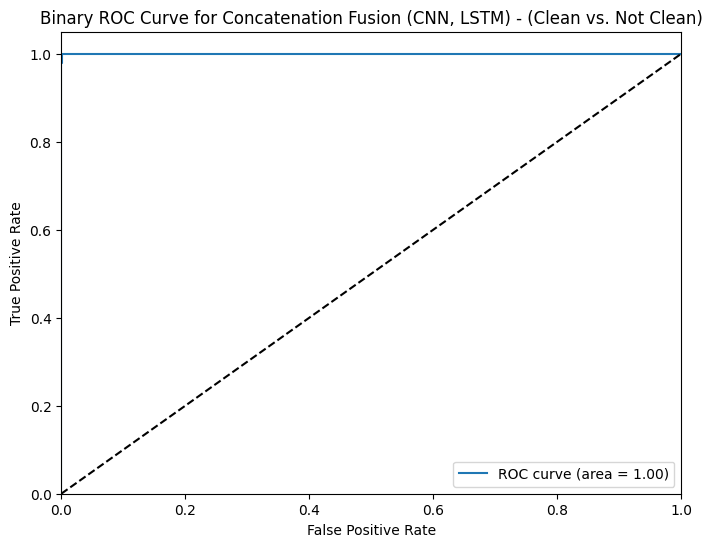


Fusing models: CNN, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       1.00      1.00      1.00       492
        html       0.98      0.95      0.97       462
          js       0.95      0.99      0.97       477
          ps       0.99      0.98      0.99       485
         url       0.99      0.99      0.99       487

    accuracy                           0.99      3204
   macro avg       0.98      0.98      0.98      3204
weighted avg       0.99      0.99      0.99      3204



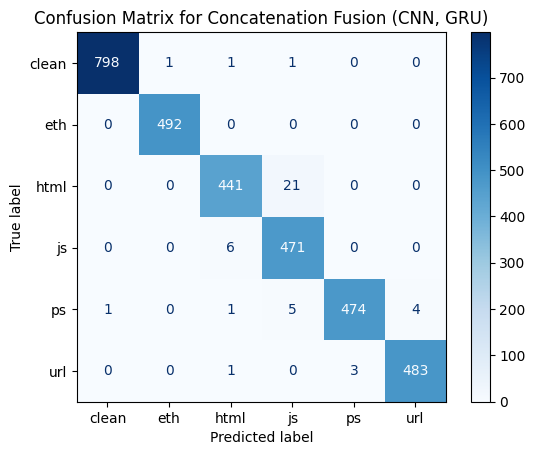

Weighted Average ROC-AUC Score (Multi-class): 0.9995


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

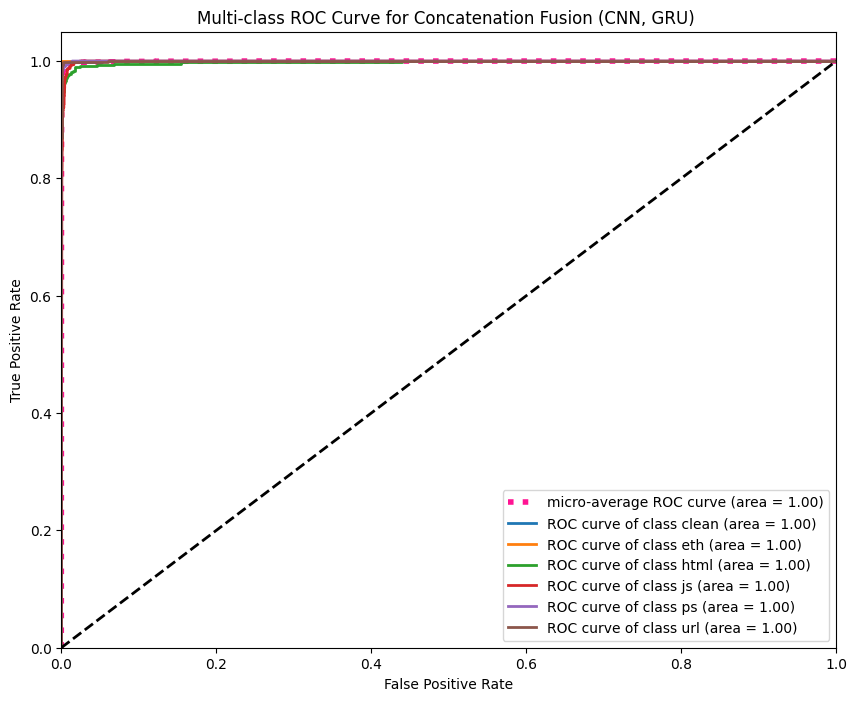


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



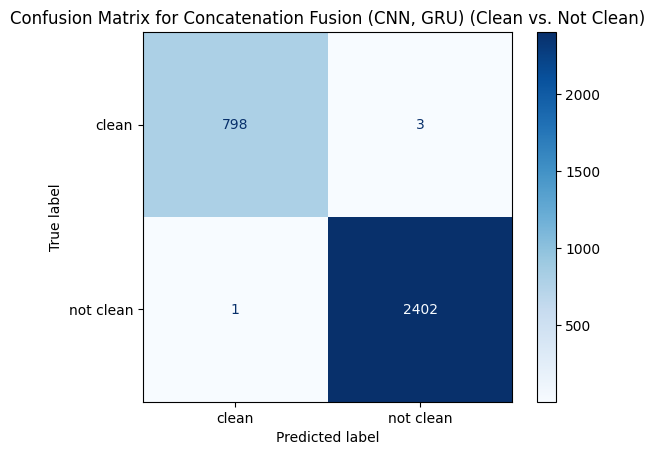

ROC-AUC Score (Clean vs. Not Clean): 0.9999


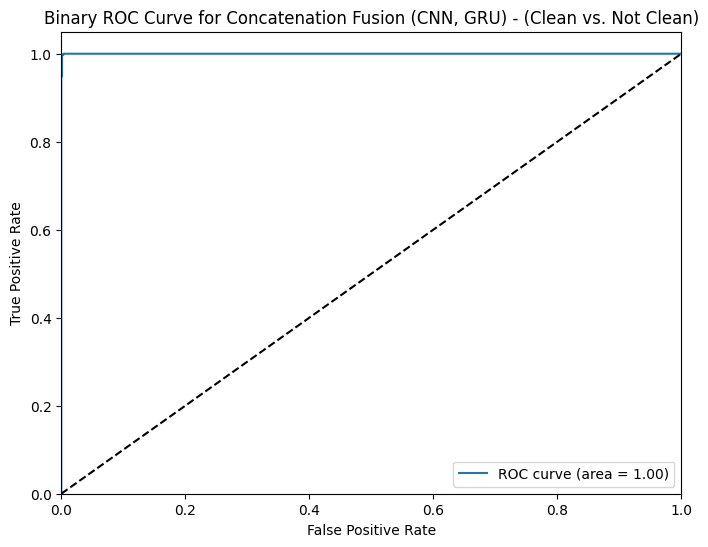


Fusing models: LSTM, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       0.25      0.99      0.40       801
         eth       0.00      0.00      0.00       492
        html       0.20      0.00      0.00       462
          js       0.33      0.00      0.01       477
          ps       0.50      0.00      0.00       485
         url       0.00      0.00      0.00       487

    accuracy                           0.25      3204
   macro avg       0.21      0.17      0.07      3204
weighted avg       0.22      0.25      0.10      3204



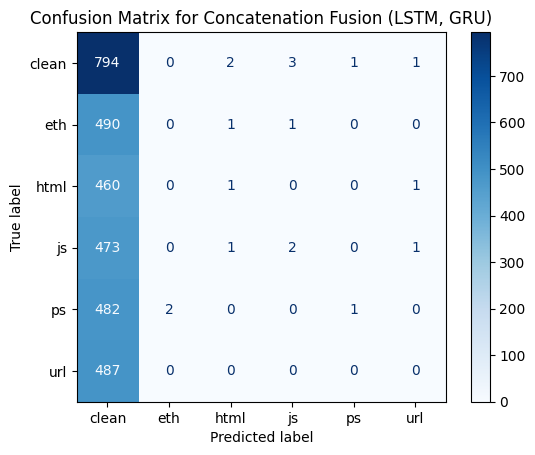

Weighted Average ROC-AUC Score (Multi-class): 0.5531


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

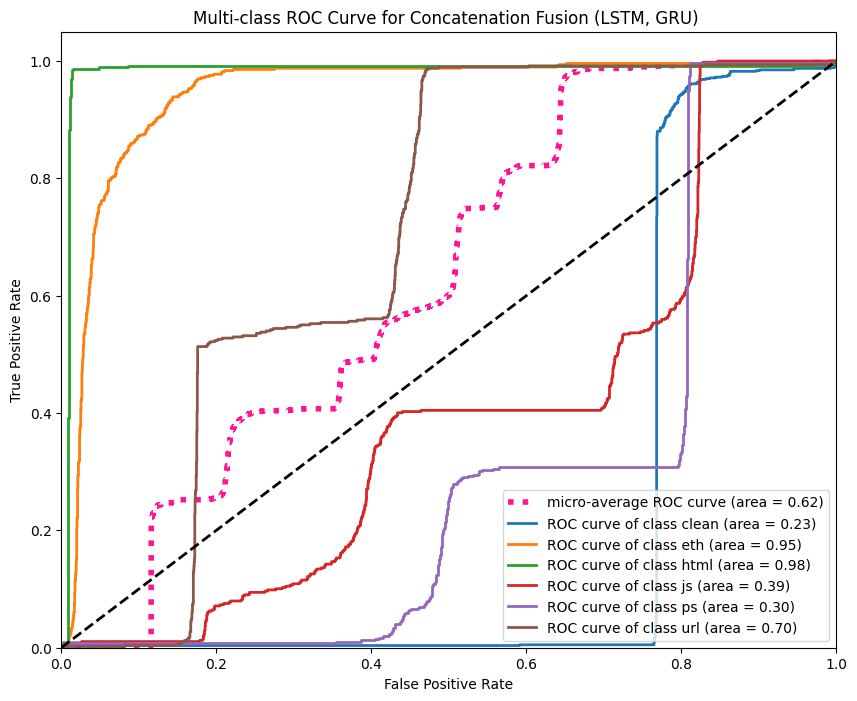


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.25      0.99      0.40       801
   not clean       0.61      0.00      0.01      2403

    accuracy                           0.25      3204
   macro avg       0.43      0.50      0.20      3204
weighted avg       0.52      0.25      0.11      3204



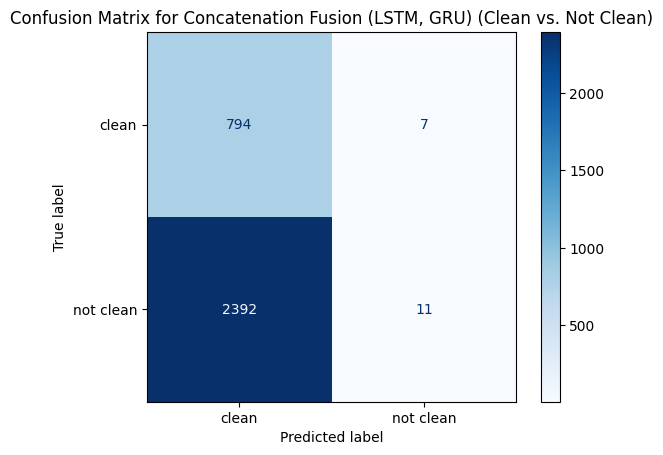

ROC-AUC Score (Clean vs. Not Clean): 0.2279


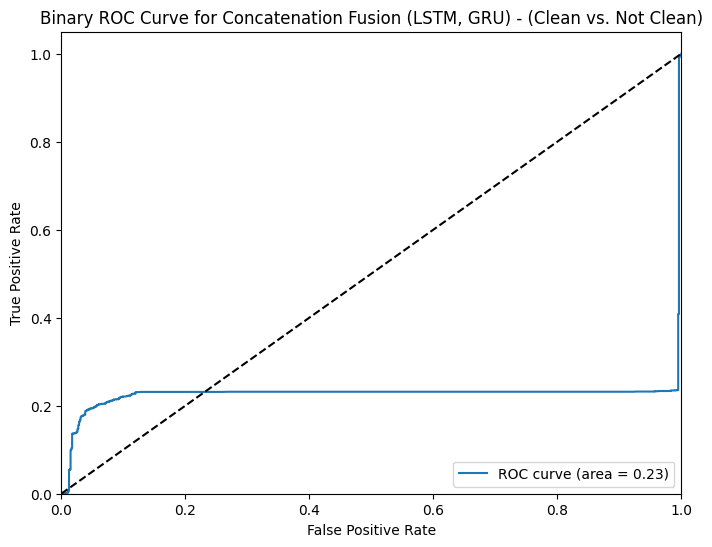


Fusing models: CNN, LSTM, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       0.99      1.00      1.00       492
        html       0.98      0.97      0.97       462
          js       0.96      0.98      0.97       477
          ps       1.00      0.97      0.98       485
         url       0.99      1.00      0.99       487

    accuracy                           0.99      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       0.99      0.99      0.99      3204



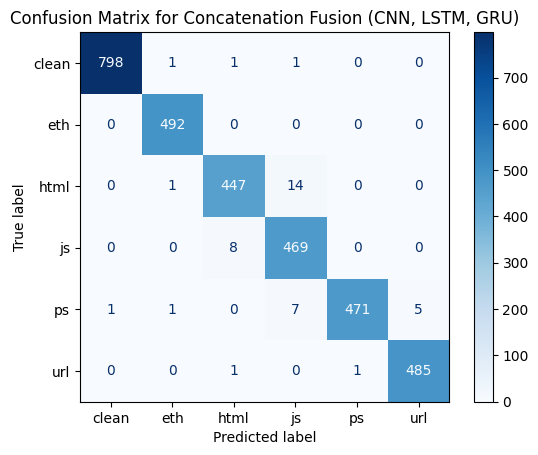

Weighted Average ROC-AUC Score (Multi-class): 0.9997


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

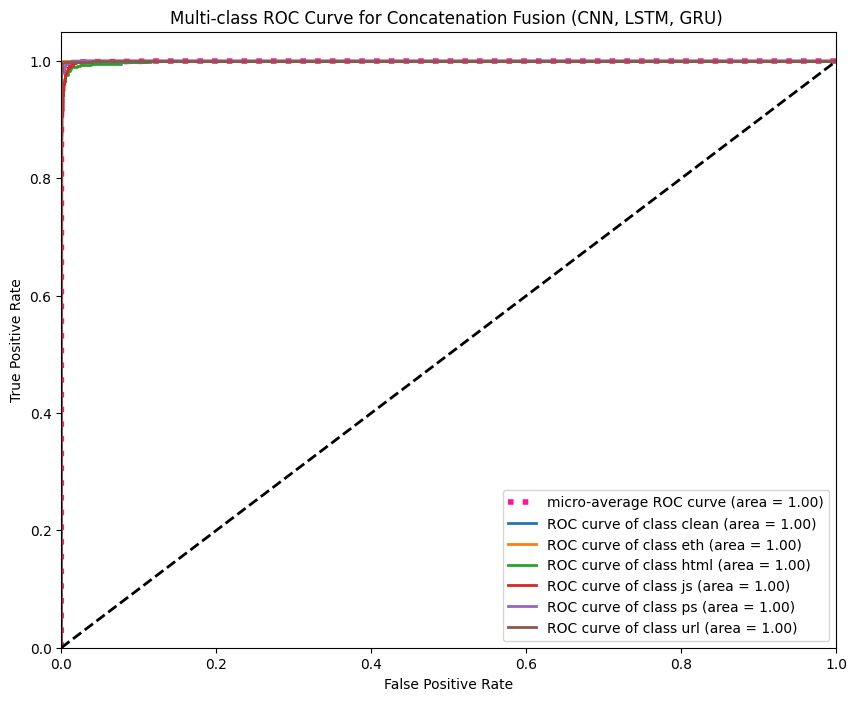


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



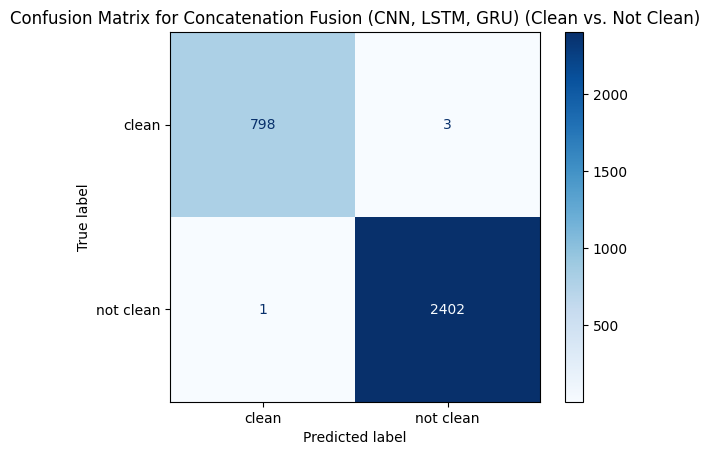

ROC-AUC Score (Clean vs. Not Clean): 0.9993


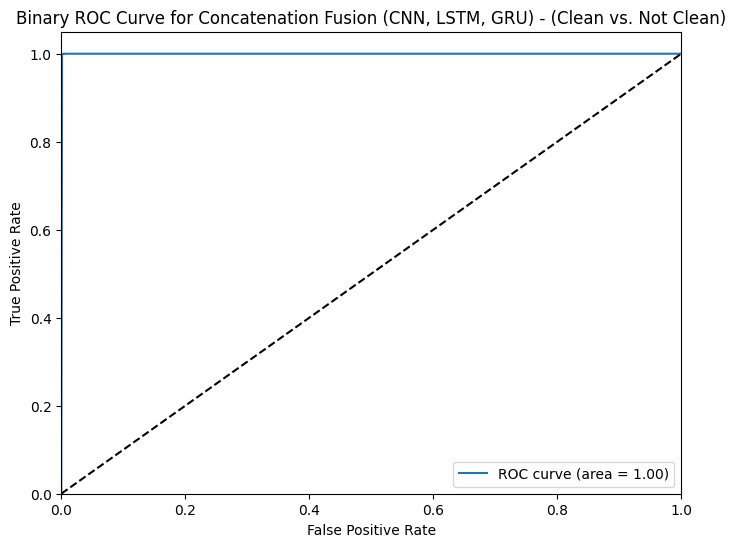

In [35]:
print("\n--- Concatenation Fusion ---")

def build_and_evaluate_concat_fusion(model_names, train_feats, val_feats, test_feats):
    print(f"\nFusing models: {', '.join(model_names)}")

    train_input = [train_features[name] for name in model_names]
    val_input = [val_features[name] for name in model_names]
    test_input = [test_features[name] for name in model_names]

    inputs = [Input(shape=train_features[name].shape[1:]) for name in model_names]
    concatenated = Concatenate()(inputs)

    x = Dense(256, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    fusion_model = Model(inputs=inputs, outputs=output)
    fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    fusion_model.fit(train_input, train_labels,
                     validation_data=(val_input, val_labels),
                     epochs=20, batch_size=BATCH_SIZE, verbose=0)

    y_pred_proba = fusion_model.predict(test_input)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Multi-class Classification Report:")
    print(classification_report(test_labels, y_pred, target_names=class_names))

    cm = confusion_matrix(test_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Concatenation Fusion ({', '.join(model_names)})")
    plt.show()

    try:
        roc_auc = roc_auc_score(test_labels, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"Weighted Average ROC-AUC Score (Multi-class): {roc_auc:.4f}")
        plot_roc_curve(test_labels, y_pred_proba, num_classes, class_names, f"Concatenation Fusion ({', '.join(model_names)}) ")
    except Exception as e:
        print(f"Could not calculate Multi-class ROC-AUC score: {e}")

    # Binary Classification (Clean vs Not Clean)
    print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

    # Map true labels to binary (0 for clean, 1 for not clean)
    y_true_binary = np.where(test_labels == class_names.index('clean'), 0, 1)

    # Map predicted classes to binary (0 for clean, 1 for not clean)
    y_pred_binary = np.where(y_pred == class_names.index('clean'), 0, 1)

    # Calculate predicted probabilities for binary classification
    # Probability of 'clean' class is the probability of class 0
    # Probability of 'not clean' is 1 - probability of class 0
    y_pred_proba_binary = np.vstack((y_pred_proba[:, class_names.index('clean')], 1 - y_pred_proba[:, class_names.index('clean')])).T


    print("Binary Classification Report:")
    print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

    cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
    disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
    disp_binary.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Concatenation Fusion ({', '.join(model_names)}) (Clean vs. Not Clean)")
    plt.show()

    try:
        # ROC-AUC for binary classification
        roc_auc_binary = roc_auc_score(y_true_binary, y_pred_proba_binary[:, 1]) # Use probability of 'not clean' class
        print(f"ROC-AUC Score (Clean vs. Not Clean): {roc_auc_binary:.4f}")

        # Plot binary ROC curve
        fpr_binary, tpr_binary, _ = roc_curve(y_true_binary, y_pred_proba_binary[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_binary, tpr_binary, label=f'ROC curve (area = {roc_auc_binary:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Binary ROC Curve for Concatenation Fusion ({", ".join(model_names)}) - (Clean vs. Not Clean)')
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print(f"Could not calculate Binary ROC-AUC score: {e}")


build_and_evaluate_concat_fusion(['CNN', 'LSTM'], train_features, val_features, test_features)
build_and_evaluate_concat_fusion(['CNN', 'GRU'], train_features, val_features, test_features)
build_and_evaluate_concat_fusion(['LSTM', 'GRU'], train_features, val_features, test_features)
build_and_evaluate_concat_fusion(['CNN', 'LSTM', 'GRU'], train_features, val_features, test_features)


--- Element-wise Product Fusion ---

Fusing models (Product): CNN, LSTM
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       0.99      1.00      1.00       492
        html       0.95      0.99      0.97       462
          js       0.98      0.95      0.97       477
          ps       0.99      0.98      0.99       485
         url       0.99      1.00      0.99       487

    accuracy                           0.99      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       0.99      0.99      0.99      3204



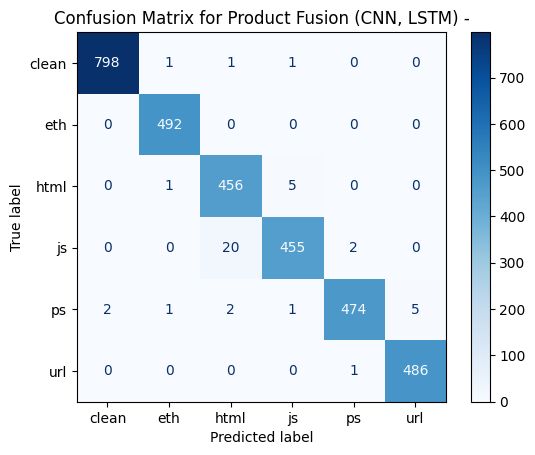

Weighted Average ROC-AUC Score (Multi-class): 0.9995


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

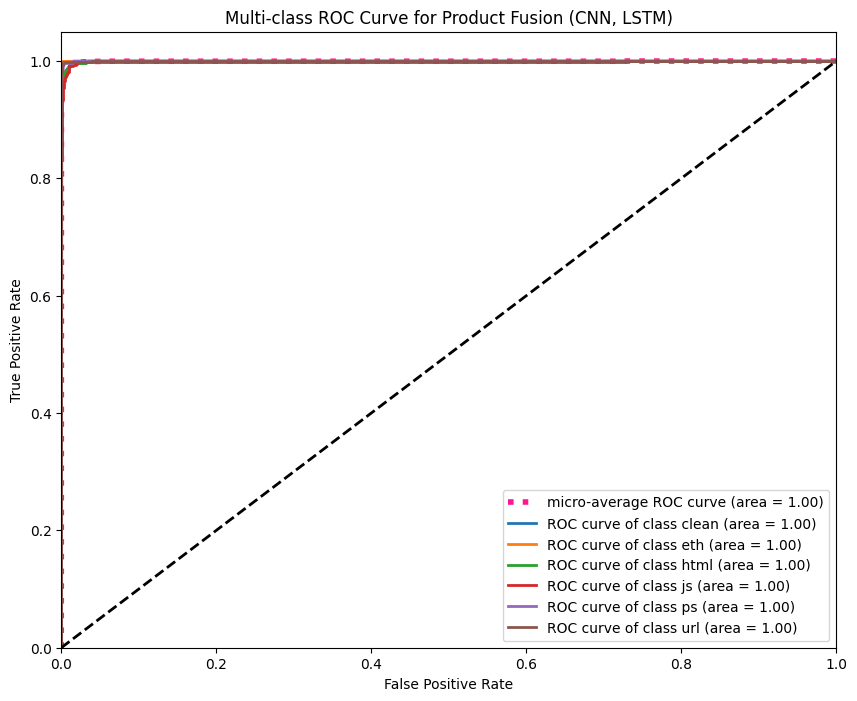


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



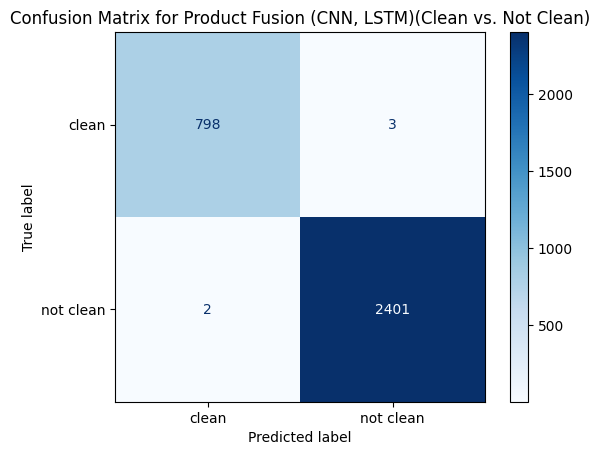

ROC-AUC Score (Clean vs. Not Clean): 0.9993


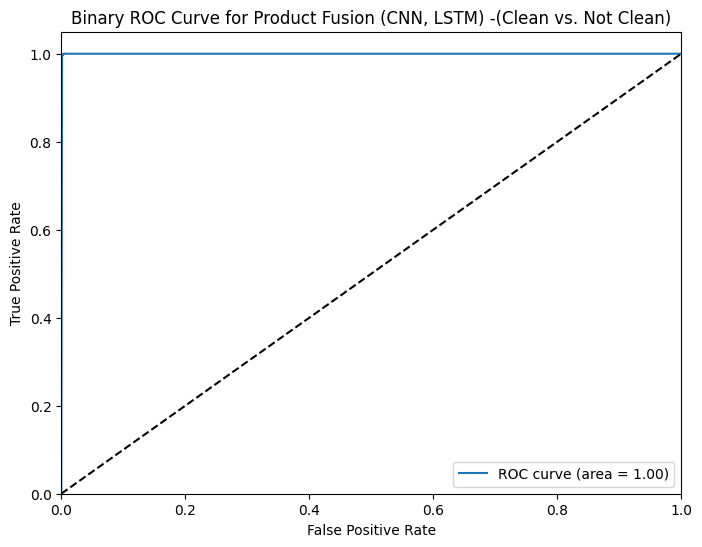


Fusing models (Product): CNN, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       1.00      1.00      1.00       492
        html       0.97      0.97      0.97       462
          js       0.97      0.97      0.97       477
          ps       0.99      0.99      0.99       485
         url       1.00      0.99      1.00       487

    accuracy                           0.99      3204
   macro avg       0.99      0.99      0.99      3204
weighted avg       0.99      0.99      0.99      3204



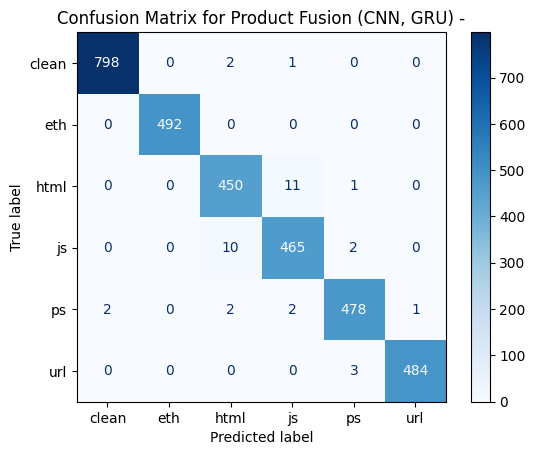

Weighted Average ROC-AUC Score (Multi-class): 0.9993


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

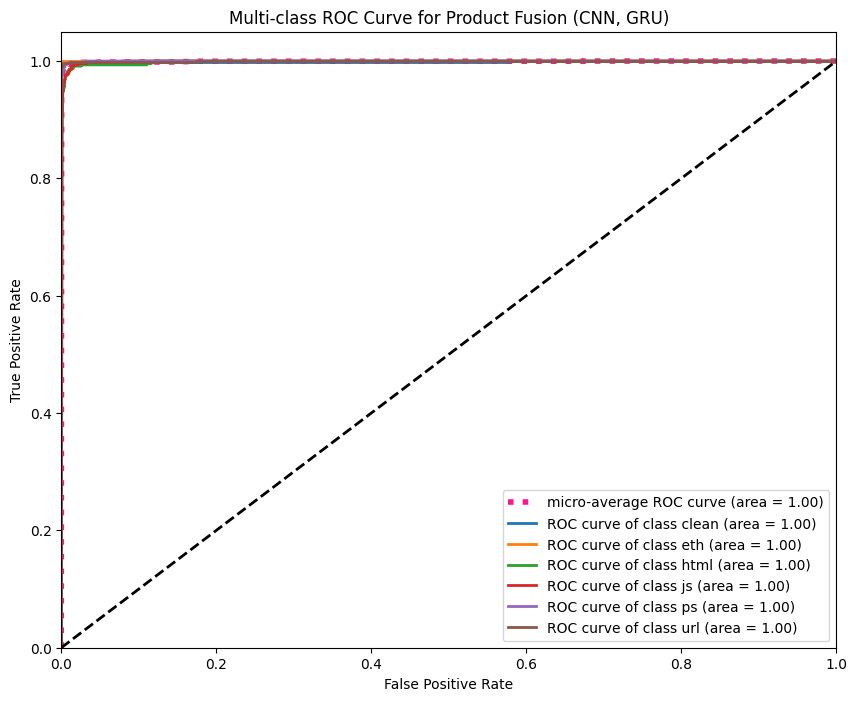


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



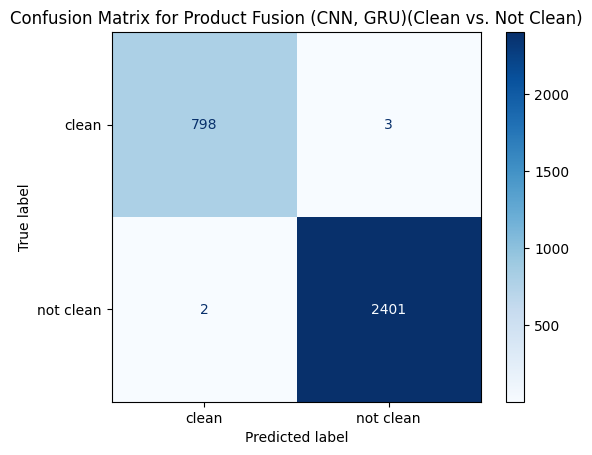

ROC-AUC Score (Clean vs. Not Clean): 0.9993


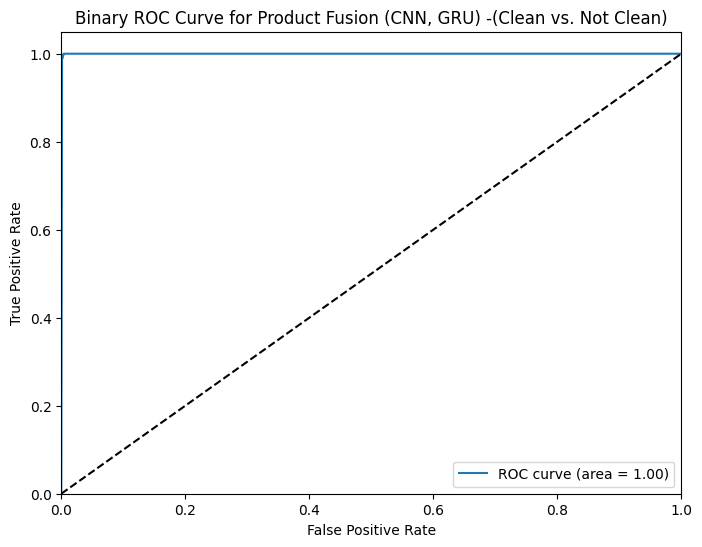


Fusing models (Product): LSTM, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       0.25      0.99      0.40       801
         eth       0.50      0.00      0.00       492
        html       0.17      0.00      0.00       462
          js       0.25      0.00      0.01       477
          ps       0.00      0.00      0.00       485
         url       0.00      0.00      0.00       487

    accuracy                           0.25      3204
   macro avg       0.19      0.17      0.07      3204
weighted avg       0.20      0.25      0.10      3204



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


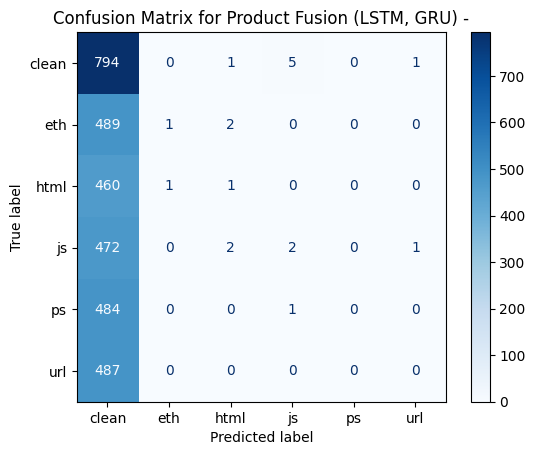

Weighted Average ROC-AUC Score (Multi-class): 0.4203


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

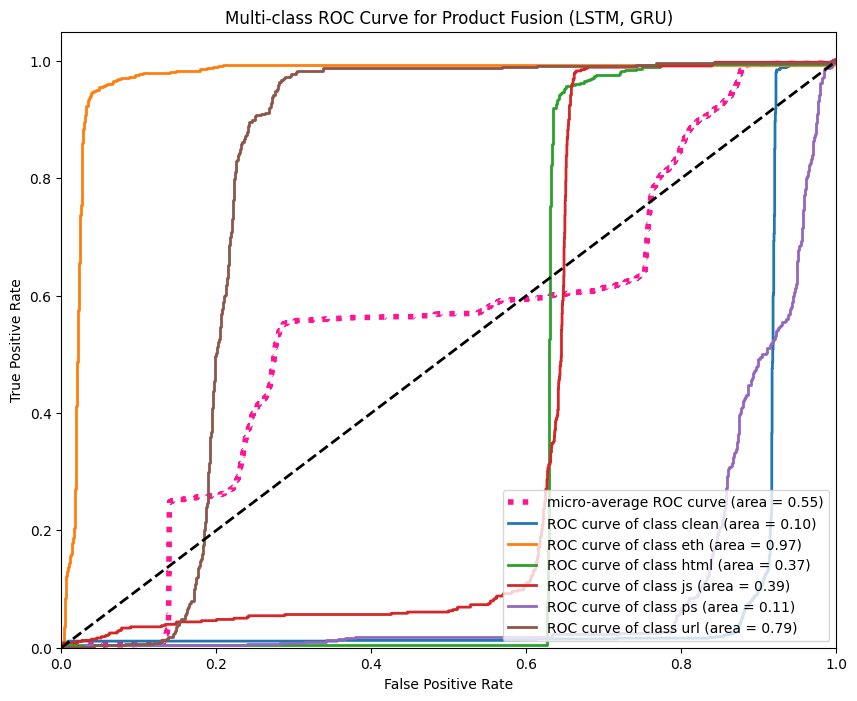


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.25      0.99      0.40       801
   not clean       0.61      0.00      0.01      2403

    accuracy                           0.25      3204
   macro avg       0.43      0.50      0.20      3204
weighted avg       0.52      0.25      0.11      3204



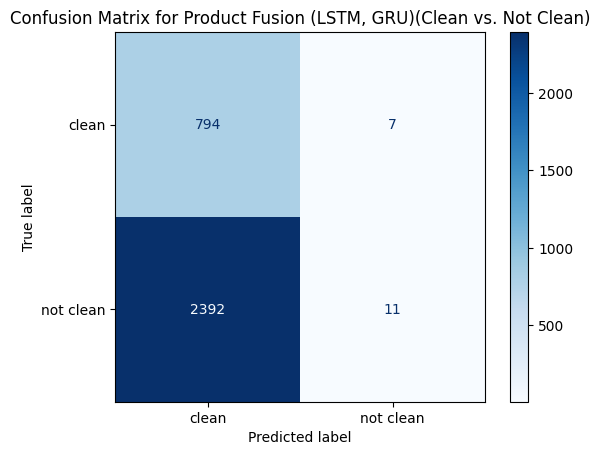

ROC-AUC Score (Clean vs. Not Clean): 0.0964


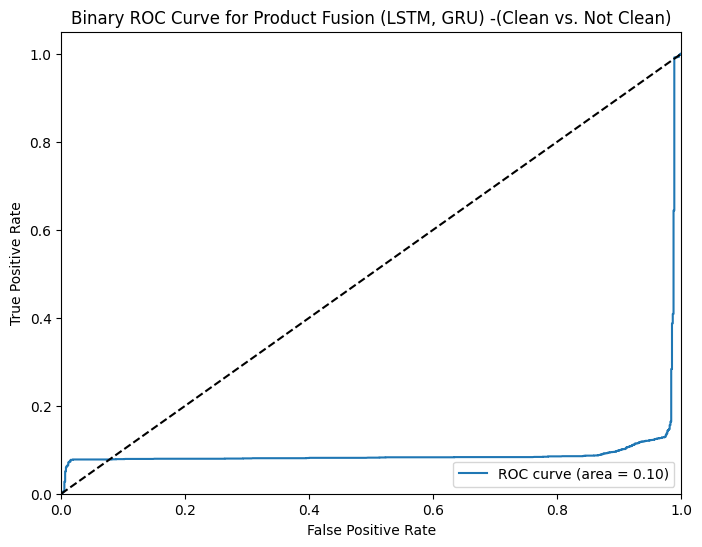


Fusing models (Product): CNN, LSTM, GRU
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Multi-class Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       1.00      1.00      1.00       492
        html       0.96      0.97      0.96       462
          js       0.96      0.97      0.96       477
          ps       0.99      0.97      0.98       485
         url       0.99      0.99      0.99       487

    accuracy                           0.98      3204
   macro avg       0.98      0.98      0.98      3204
weighted avg       0.98      0.98      0.98      3204



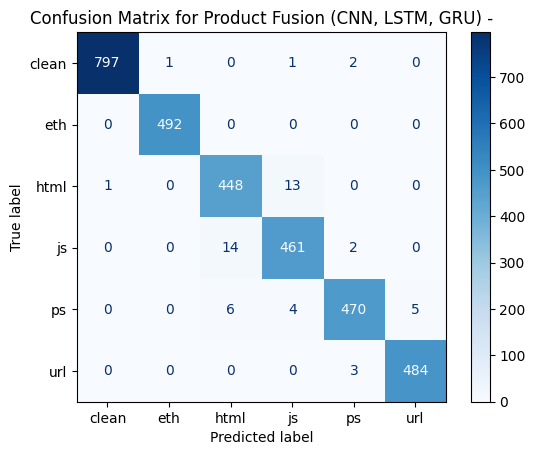

Weighted Average ROC-AUC Score (Multi-class): 0.9992


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

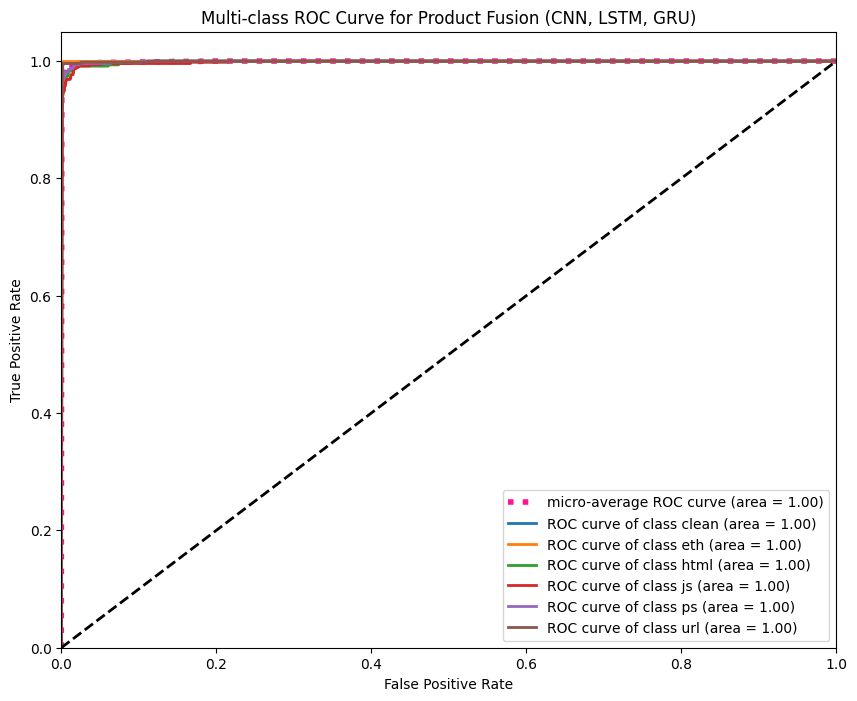


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



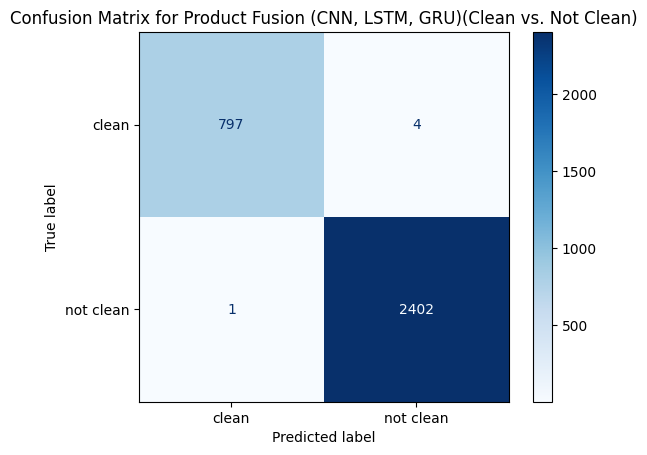

ROC-AUC Score (Clean vs. Not Clean): 0.9993


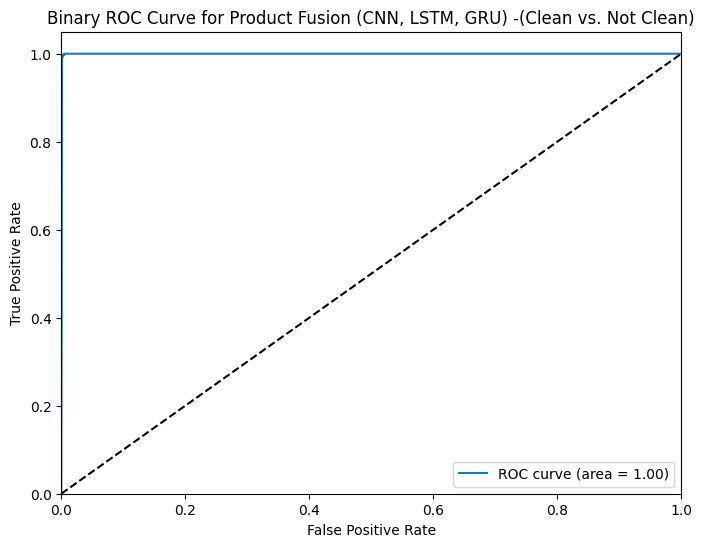

In [36]:
print("\n--- Element-wise Product Fusion ---")
PROJECTION_DIM = 128

def build_and_evaluate_product_fusion(model_names, train_feats, val_feats, test_feats):
    print(f"\nFusing models (Product): {', '.join(model_names)}")

    inputs = [Input(shape=train_features[name].shape[1:]) for name in model_names]
    projected_layers = [Dense(PROJECTION_DIM, activation='relu')(inp) for inp in inputs]

    multiplied = Multiply()(projected_layers)

    x = Dense(128, activation='relu')(multiplied)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    fusion_model = Model(inputs=inputs, outputs=output)
    fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    train_input = [train_features[name] for name in model_names]
    val_input = [val_features[name] for name in model_names]
    test_input = [test_features[name] for name in model_names]

    fusion_model.fit(train_input, train_labels,
                     validation_data=(val_input, val_labels),
                     epochs=20, batch_size=BATCH_SIZE, verbose=0)

    y_pred_proba = fusion_model.predict(test_input)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print("Multi-class Classification Report:")
    print(classification_report(test_labels, y_pred, target_names=class_names))

    cm = confusion_matrix(test_labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Product Fusion ({', '.join(model_names)}) -")
    plt.show()

    try:
        roc_auc = roc_auc_score(test_labels, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"Weighted Average ROC-AUC Score (Multi-class): {roc_auc:.4f}")
        plot_roc_curve(test_labels, y_pred_proba, num_classes, class_names, f"Product Fusion ({', '.join(model_names)})")
    except Exception as e:
        print(f"Could not calculate Multi-class ROC-AUC score: {e}")

    # Binary Classification (Clean vs Not Clean)
    print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

    # Map true labels to binary (0 for clean, 1 for not clean)
    y_true_binary = np.where(test_labels == class_names.index('clean'), 0, 1)

    # Map predicted classes to binary (0 for clean, 1 for not clean)
    y_pred_binary = np.where(y_pred == class_names.index('clean'), 0, 1)

    # Calculate predicted probabilities for binary classification
    # Probability of 'clean' class is the probability of class 0
    # Probability of 'not clean' is 1 - probability of class 0
    y_pred_proba_binary = np.vstack((y_pred_proba[:, class_names.index('clean')], 1 - y_pred_proba[:, class_names.index('clean')])).T


    print("Binary Classification Report:")
    print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

    cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
    disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
    disp_binary.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for Product Fusion ({', '.join(model_names)})(Clean vs. Not Clean)")
    plt.show()

    try:
        # ROC-AUC for binary classification
        roc_auc_binary = roc_auc_score(y_true_binary, y_pred_proba_binary[:, 1]) # Use probability of 'not clean' class
        print(f"ROC-AUC Score (Clean vs. Not Clean): {roc_auc_binary:.4f}")

        # Plot binary ROC curve
        fpr_binary, tpr_binary, _ = roc_curve(y_true_binary, y_pred_proba_binary[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_binary, tpr_binary, label=f'ROC curve (area = {roc_auc_binary:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Binary ROC Curve for Product Fusion ({", ".join(model_names)}) -(Clean vs. Not Clean)')
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
        print(f"Could not calculate Binary ROC-AUC score: {e}")

build_and_evaluate_product_fusion(['CNN', 'LSTM'], train_features, val_features, test_features)
build_and_evaluate_product_fusion(['CNN', 'GRU'], train_features, val_features, test_features)
build_and_evaluate_product_fusion(['LSTM', 'GRU'], train_features, val_features, test_features)
build_and_evaluate_product_fusion(['CNN', 'LSTM', 'GRU'], train_features, val_features, test_features)

### 7. Combination Technique 2: Ensemble Voting

In [37]:
print("\n--- Combination Technique 2: Ensemble Voting ---")

all_pred_probas = {}
for name, model in trained_models.items():
    print(f"Getting predictions from {name}...")
    if name == 'ViT':
        predictions_list = []
        for images, labels in test_ds_vit:
            # Apply preprocessing for ViT model: rescale and transpose
            images = tf.image.convert_image_dtype(images, dtype=tf.float32)
            images = tf.transpose(images, perm=[0, 3, 1, 2])
            preds = model.predict({'pixel_values': images})
            # Extract logits from the prediction output
            predictions_list.append(preds.logits)
        predictions = np.concatenate(predictions_list, axis=0)
        all_pred_probas[name] = tf.nn.softmax(predictions, axis=-1).numpy()
    else:
        all_pred_probas[name] = model.predict(test_ds_gen)

y_true_ensemble = np.concatenate([y for x, y in test_ds_gen], axis=0)


--- Combination Technique 2: Ensemble Voting ---
Getting predictions from CNN...
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
Getting predictions from LSTM...
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
Getting predictions from GRU...
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Getting predictions from ViT...
1/1 [==============================] - 0s 41ms/step



--- Hard Voting (Majority Voting) ---
Classification Report (Hard Voting):
              precision    recall  f1-score   support

       clean       0.99      1.00      0.99       801
         eth       1.00      1.00      1.00       492
        html       0.99      1.00      1.00       462
          js       1.00      0.99      0.99       477
          ps       1.00      0.98      0.99       485
         url       1.00      1.00      1.00       487

    accuracy                           1.00      3204
   macro avg       1.00      0.99      1.00      3204
weighted avg       1.00      1.00      1.00      3204



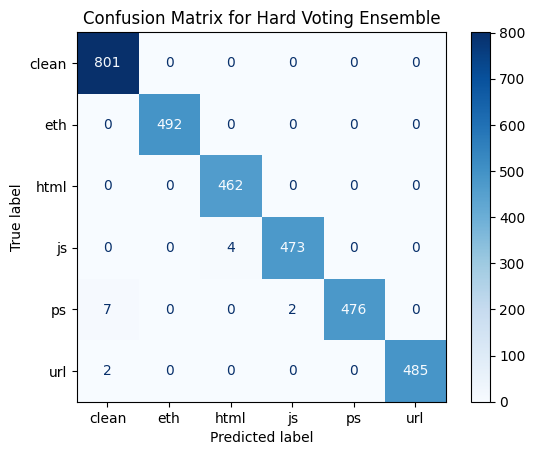

ROC-AUC curve is not applicable for Hard Voting based on predicted classes.

--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       0.99      1.00      0.99       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       0.99      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



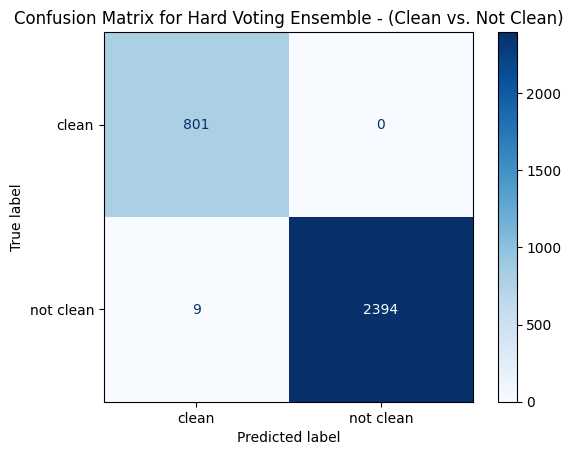

ROC-AUC curve is not typically calculated for Hard Voting binary classification based on predicted classes.


In [38]:
print("\n--- Hard Voting (Majority Voting) ---")
all_preds = [np.argmax(p, axis=1) for p in all_pred_probas.values()]
stacked_preds = np.stack(all_preds, axis=1)

hard_vote_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_preds)

print("Classification Report (Hard Voting):")
print(classification_report(y_true_ensemble, hard_vote_preds, target_names=class_names))

cm_hard = confusion_matrix(y_true_ensemble, hard_vote_preds)
disp_hard = ConfusionMatrixDisplay(confusion_matrix=cm_hard, display_labels=class_names)
disp_hard.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Hard Voting Ensemble")
plt.show()

# ROC-AUC is not typically calculated for hard voting directly on the predicted classes.
# It requires probability scores. We can skip plotting ROC for hard voting
print("ROC-AUC curve is not applicable for Hard Voting based on predicted classes.")
# Binary Classification (Clean vs Not Clean)
print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

# Map true labels to binary (0 for clean, 1 for not clean)
y_true_binary = np.where(y_true_ensemble == class_names.index('clean'), 0, 1)

# Map predicted classes to binary (0 for clean, 1 for not clean)
y_pred_binary = np.where(hard_vote_preds == class_names.index('clean'), 0, 1)

print("Binary Classification Report:")
print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
disp_binary.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Hard Voting Ensemble - (Clean vs. Not Clean)")
plt.show()

print("ROC-AUC curve is not typically calculated for Hard Voting binary classification based on predicted classes.")


--- Soft Voting (Averaging Probabilities) ---
Classification Report (Soft Voting):
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
         eth       1.00      1.00      1.00       492
        html       1.00      1.00      1.00       462
          js       0.99      1.00      1.00       477
          ps       1.00      0.99      0.99       485
         url       1.00      1.00      1.00       487

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



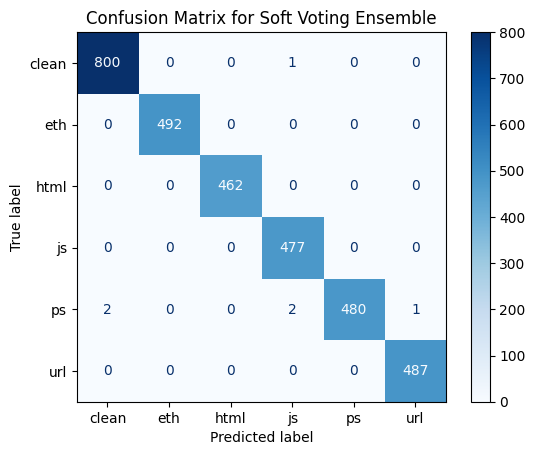

Weighted Average ROC-AUC Score (Soft Voting): 1.0000


/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  roc_auc[i] = np.trapz(tpr[i], fpr[i])
/tmp/ipython-input-20-3122795124.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

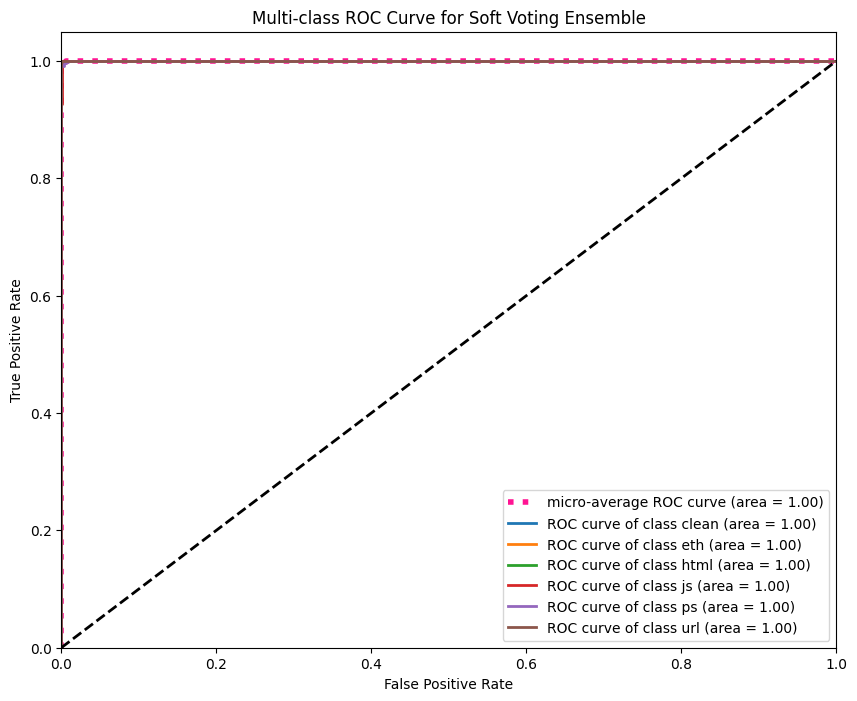


--- Binary Classification Report (Clean vs. Not Clean) ---
Binary Classification Report:
              precision    recall  f1-score   support

       clean       1.00      1.00      1.00       801
   not clean       1.00      1.00      1.00      2403

    accuracy                           1.00      3204
   macro avg       1.00      1.00      1.00      3204
weighted avg       1.00      1.00      1.00      3204



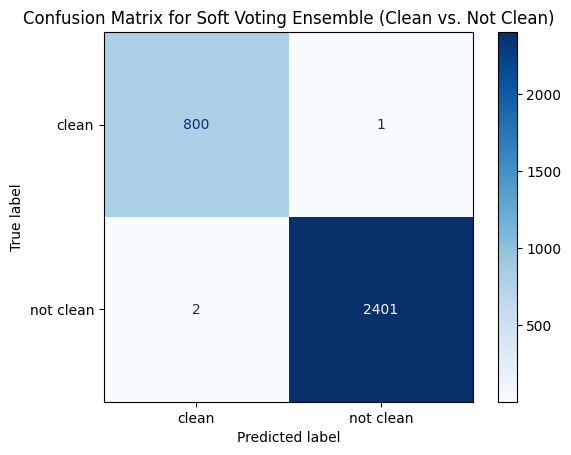

ROC-AUC Score (Soft Voting - Clean vs. Not Clean): 1.0000


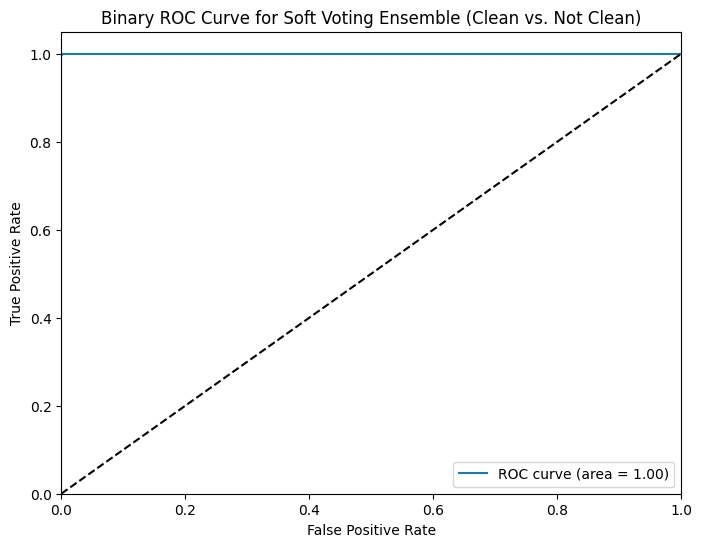

In [39]:
print("\n--- Soft Voting (Averaging Probabilities) ---")
avg_proba = np.mean(list(all_pred_probas.values()), axis=0)
soft_vote_preds = np.argmax(avg_proba, axis=1)

print("Classification Report (Soft Voting):")
print(classification_report(y_true_ensemble, soft_vote_preds, target_names=class_names))

cm_soft = confusion_matrix(y_true_ensemble, soft_vote_preds)
disp_soft = ConfusionMatrixDisplay(confusion_matrix=cm_soft, display_labels=class_names)
disp_soft.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Soft Voting Ensemble")
plt.show()

roc_auc_soft = roc_auc_score(y_true_ensemble, avg_proba, multi_class='ovr', average='weighted')
print(f"Weighted Average ROC-AUC Score (Soft Voting): {roc_auc_soft:.4f}")

plot_roc_curve(y_true_ensemble, avg_proba, num_classes, class_names, "Soft Voting Ensemble")

# Binary Classification (Clean vs Not Clean)
print("\n--- Binary Classification Report (Clean vs. Not Clean) ---")

# Map true labels to binary (0 for clean, 1 for not clean)
y_true_binary = np.where(y_true_ensemble == class_names.index('clean'), 0, 1)

# Calculate predicted probabilities for binary classification
# Probability of 'clean' class is the probability of class 0
# Probability of 'not clean' is 1 - probability of class 0
y_pred_proba_binary = np.vstack((avg_proba[:, class_names.index('clean')], 1 - avg_proba[:, class_names.index('clean')])).T

# Map predicted classes to binary (0 for clean, 1 for not clean) based on soft voting predictions
y_pred_binary = np.where(soft_vote_preds == class_names.index('clean'), 0, 1)


print("Binary Classification Report:")
print(classification_report(y_true_binary, y_pred_binary, target_names=['clean', 'not clean']))

cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=['clean', 'not clean'])
disp_binary.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Soft Voting Ensemble (Clean vs. Not Clean)")
plt.show()

try:
    # ROC-AUC for binary classification
    roc_auc_binary = roc_auc_score(y_true_binary, y_pred_proba_binary[:, 1]) # Use probability of 'not clean' class
    print(f"ROC-AUC Score (Soft Voting - Clean vs. Not Clean): {roc_auc_binary:.4f}")

    # Plot binary ROC curve
    fpr_binary, tpr_binary, _ = roc_curve(y_true_binary, y_pred_proba_binary[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_binary, tpr_binary, label=f'ROC curve (area = {roc_auc_binary:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Binary ROC Curve for Soft Voting Ensemble (Clean vs. Not Clean)')
    plt.legend(loc="lower right")
    plt.show()

except Exception as e:
    print(f"Could not calculate Binary ROC-AUC score: {e}")